<a href="https://colab.research.google.com/github/Hyeseong0317/Pytorch_Capstone_Design/blob/main/pytorch_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
!pip install torchvision

In [43]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [44]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정
torch.manual_seed(777)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [14]:
USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하면 True, 아니라면 False를 리턴
device = torch.device("cuda" if USE_CUDA else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cuda


In [45]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(400),                         
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.RandomResizedCrop(400), 
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        transforms.RandomResizedCrop(400),                        
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}

In [46]:
data_dir = '/content/drive/Shareddrives/8:1:1/OCT2017(8:1:1)'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                    for x in ['train', 'val', 'test']}


In [47]:
train_dataloader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=110,
                                             shuffle=True, drop_last=True, num_workers=2)
                    for x in ['train']}

val_dataloader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=14,
                                             shuffle=True, drop_last=True, num_workers=2)
                    for x in ['val']}                   

test_dataloader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=14,
                                             shuffle=True, drop_last=True, num_workers=2)
                    for x in ['test']}



dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


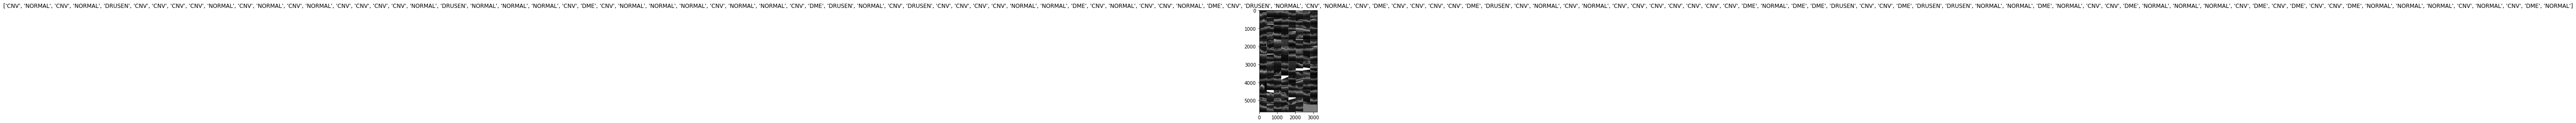

In [48]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(train_dataloader['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [49]:
import torch
import torch.nn as nn

inputs = torch.Tensor(1, 1, 400, 400)
print('텐서의 크기 : {}'.format(inputs.shape))

텐서의 크기 : torch.Size([1, 1, 400, 400])


In [51]:
conv1 = nn.Conv2d(1, 32, 3, padding=1)
print(conv1)

conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
print(conv2)

pool = nn.MaxPool2d(2)
print(pool)

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


In [52]:
out = conv1(inputs)
print(out.shape)

out = conv2(out)
print(out.shape)

out = pool(out)
print(out.shape)

out = pool(out)
print(out.shape)

torch.Size([1, 32, 400, 400])
torch.Size([1, 64, 400, 400])
torch.Size([1, 64, 200, 200])
torch.Size([1, 64, 100, 100])


In [53]:
out = out.view(out.size(0), -1) 
print(out.shape)

torch.Size([1, 640000])


In [54]:
model = torch.nn.Sequential(
    conv1,
    torch.nn.ReLU(),
    pool,
    conv2,
    torch.nn.ReLU(),
    pool,
    torch.nn.Linear(100 * 100 * 64, 4, bias=True) # 최종 output 400*400 (Maxpooling) -> 200*200 (Maxpooling) -> 100*100 pixels, 채널수 1 -> 32 -> 64, 즉 100*100 pixels, 64채널의 output과 4개의 분류(CNV,DME, DRUSEN, NORMAL)
).to(device)

In [55]:
model

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Linear(in_features=640000, out_features=4, bias=True)
)

In [56]:
training_epochs = 1
learning_rate = 0.001
total_batch = len(train_dataloader['train'])
print('총 배치의 수 : {}'.format(total_batch))

총 배치의 수 : 616


In [57]:
len(test_dataloader['test'])

590

In [58]:
criterion = torch.nn.CrossEntropyLoss().to(device)    # 비용 함수에 소프트맥스 함수 포함되어져 있음.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [60]:
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in train_dataloader['train']: # 미니 배치 단위로 꺼내온다. X는 미니 배치, Y는 레이블.
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

RuntimeError: ignored

In [ ]:
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())